In [2]:
import pandas as pd
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon
from ipywidgets import Dropdown, interact
from IPython.display import clear_output
ox.config(log_console=True, use_cache=True)

%matplotlib inline

In [3]:
DATOS_PROCESADOS = Path("../datos/procesados/")

In [4]:
datos = pd.read_csv(DATOS_PROCESADOS / 'base_de_datos-05-jul-19.csv', encoding = 'utf-8',)

In [5]:
def filtra_datos(nombre):
    _datos = datos[datos['Nombre'] == nombre]
    return _datos

In [6]:
lista_de_nombres = list(datos['Nombre'].values)

In [7]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False, trip_times = [], center_node = None):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lines.append(LineString([f,t]))

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        
        # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

In [8]:
def visualiza_isocronos(
    nombre
):
    clear_output()
    df = filtra_datos(nombre = nombre)
    
    direccion = df['Dirección OSMNx'].values[0]
    ciudad = df['Ciudad'].values[0]
    
    network_type = 'walk'
    trip_times = [5, 10, 15, 20, 25, 30] #in minutes
    travel_speed = 4.5 #walking speed in km/hour
    # download the street network
    try:
        G = ox.graph_from_address(direccion, distance = 3000, network_type=network_type)
    except:
        print("No encontramos esa dirección pero aquí esta un isocrono de la ciudad en la que se encuentra esa institución.")
        G = ox.graph_from_place(f"{ciudad}, CA", network_type = "walk")
        
    # find the centermost node and then project the graph to UTM
    gdf_nodes = ox.graph_to_gdfs(G, edges=False)
    x, y = gdf_nodes['geometry'].unary_union.centroid.xy
    center_node = ox.get_nearest_node(G, (y[0], x[0]))
    G = ox.project_graph(G)
    
    # add an edge attribute for time in minutes required to traverse each edge
    meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
    for u, v, k, data in G.edges(data=True, keys=True):
        data['time'] = data['length'] / meters_per_minute
        
    # get one color for each isochrone
    iso_colors = ox.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)
    
    isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True, trip_times=trip_times, center_node = center_node)
    fig, ax = ox.plot_graph(G, fig_height=8, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
    for polygon, fc in zip(isochrone_polys, iso_colors):
        if type(polygon) == Polygon:
            patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
            ax.add_patch(patch)
        else:
            pass
        
    plt.tight_layout()
    plt.suptitle(f"{nombre} en {ciudad}, California, EEUU", horizontalalignment='left', fontsize=16, y=1.05, x=0.04)
    plt.title("30 minutos caminando", loc='left', fontdict={'fontsize':12}, x=0.02);
    
    plt.show();

# Mapas isócronos utilizando `OSMNx`, `ipywidgets` y `voilà`

<dl>
  <dt>isócrono, na.</dt>
  <dd>
      <i>Del gr. ἰσόχρονος isóchronos 'de igual duración'.</i><br>
    1. adj. Fís. Dicho de dos o más movimientos: Que se hacen en tiempos de igual duración.
  </dd>
</dl>

Para explorar el concepto de mapas isócronos decidí utilizar datos del _Integrated Postsecondary Education Data System_ (IPEDS) con los que estoy familiarizado por mi trabajo. 

Tomé datos de las universidades públicas de California y estoy visualizando que tan lejos alguien puede llegar caminando por 30 minutos. Si algún estudiante que no tiene acceso a un automóvil estuviera pensando en mudarse más cerca de su universidad y no quiere caminar más de 30 minutos, esto nos da una idea más o menos de donde podría vivir. 

Esto es un prototipo o _prueba de concepto_. Así como escogí universidades públicas de California, podríamos escoger otros lugares en el mundo. Estos mapas son creados con [`OSMNx` de Geoff Boeing](https://osmnx.readthedocs.io/en/stable/index.html) la cual utiliza _Open Street Map_ así que en teoría podríamos buscar direcciones en muchos países (no sólo EEUU). 

Teniendo este prototipo ahora solo es cuestión de usar una base de datos diferente si quisieramos explorar, por ejemplo, escuelas primarias en Perú o hospitales en Colombia o restaurantes en Chile. 

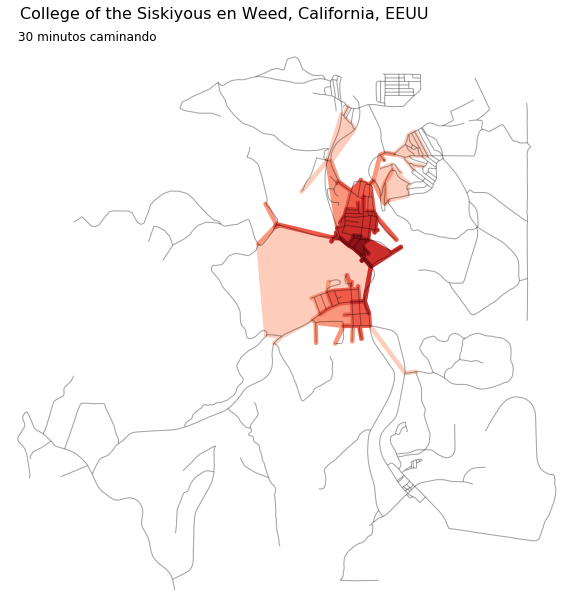

In [19]:
interact(visualiza_isocronos, nombre = Dropdown(options = lista_de_nombres, description = "Institución", value="College of the Siskiyous"));

Estos son creados utilizando `matplotlib` ya que `OSMNx` utiliza entre otros paquetes `NetworkX` y `GeoPandas` para crear estos gráficos.


¿Qué te parece voila? [Mandanos un tuit a @tacosdedatos](https://twitter.com/share?text=Obvio+que+estuvo+super+el+blog+%40tacosdedatos+%F0%9F%8C%AE) o un correo a [✉️ sugerencias@tacosdedatos.com](mailto:sugerencias@tacosdedatos.com?subject=Sugerencia&body=Hola-holaaa).